# Vehicle Detection and Tracking
---
---

## The Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

## All imports needed for this project

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
import time
import pickle
from skimage.feature import hog
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label

---
## Dataset Summary & Exploration
---

### Provide a Basic Summary of the Data Set

In [2]:
# Images are divided up into vehicles and non-vehicles (each of which contains sub folders)

# Placeholders for images
cars = []
notcars = []

# Locate vehicle images
basedir = 'vehicles/'

# Different folders represent different sources for images
image_types = os.listdir(basedir)

# Load the images
for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))

# Locate non-vehicle images
basedir = 'non-vehicles/'

# Different folders represent different sources for images
image_types = os.listdir(basedir)

# Load the images
for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))
    
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print("Number of car images =", data_info["n_cars"])
print("Number of non-car images =", data_info["n_notcars"])
print("Image shape =", data_info["image_shape"])
print("Data type =", data_info["data_type"])


Number of car images = 8792
Number of non-car images = 8968
Image shape = (64, 64, 3)
Data type = float32


### Include an exploratory visualization of the dataset

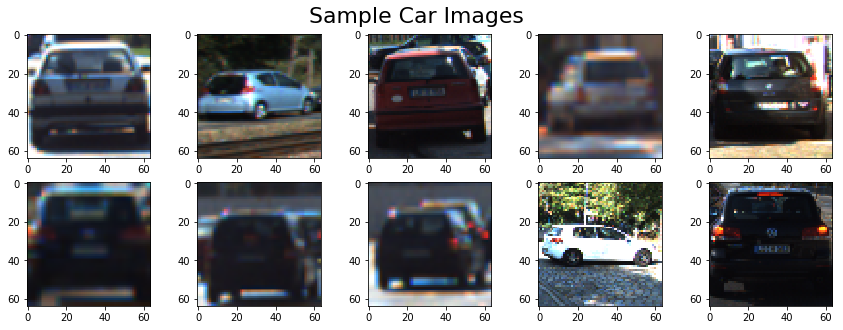

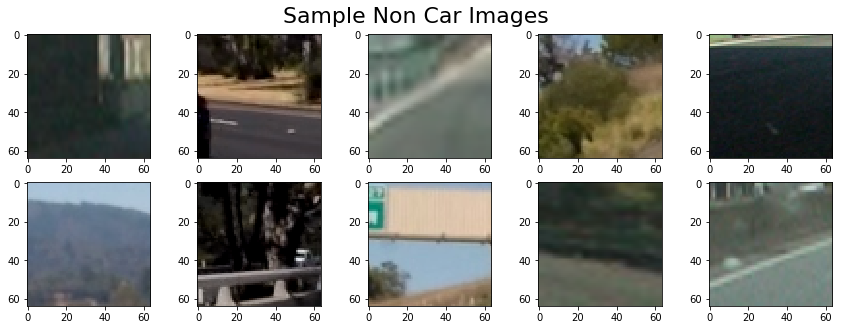

In [3]:
### Data exploration visualization code goes here.

# Visualizations will be shown in the notebook.

plt.rcdefaults()
%matplotlib inline

### Show random car images.
fig = plt.figure(figsize=(15, 5))
fig.suptitle('Sample Car Images', fontsize=22, verticalalignment='bottom', y =0.9)
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    car_ind = np.random.randint(0, len(cars))
    car_image = cv2.imread(cars[car_ind])
    car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)
    plt.imshow(car_image)
    #plt.axis('off')
fig.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

### Show random non-car images.
fig = plt.figure(figsize=(15, 5))
fig.suptitle('Sample Non Car Images', fontsize=22, verticalalignment='bottom', y =0.9)
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    notcar_ind = np.random.randint(0, len(notcars))
    notcar_image = cv2.imread(notcars[notcar_ind])
    notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_BGR2RGB)
    plt.imshow(notcar_image)
    #plt.axis('off')
fig.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()



---
## Feature Extraction
---

### Histograms of Color

In [4]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


(96,)


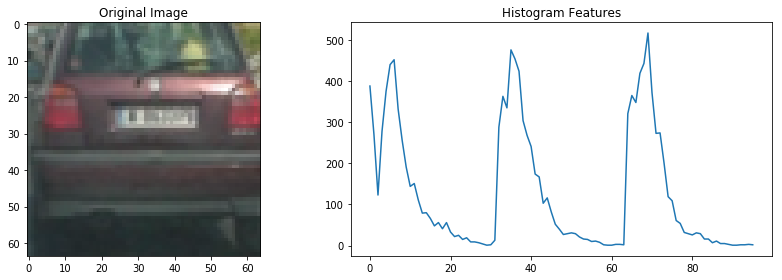

In [5]:
# Generate a random index to look at a car image
car_ind = np.random.randint(0, len(cars))

# Read in the image
image = cv2.imread(cars[car_ind])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hist_features = color_hist(image)
print(hist_features.shape)
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(122)
plt.plot(hist_features)
plt.title('Histogram Features')
fig.tight_layout()

---
### Spatial Binning of Color

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

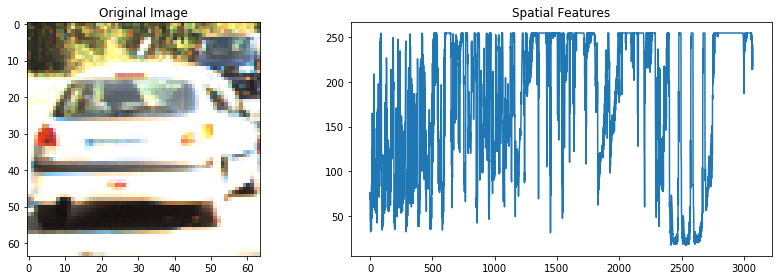

In [7]:
# Generate a random index to look at a car image
car_ind = np.random.randint(0, len(cars))

# Read in the image
image = cv2.imread(cars[car_ind])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
spatial_features = bin_spatial(image)
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(122)
plt.plot(spatial_features)
plt.title('Spatial Features')
fig.tight_layout()

---
### HOG Features

In [8]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

D:\miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


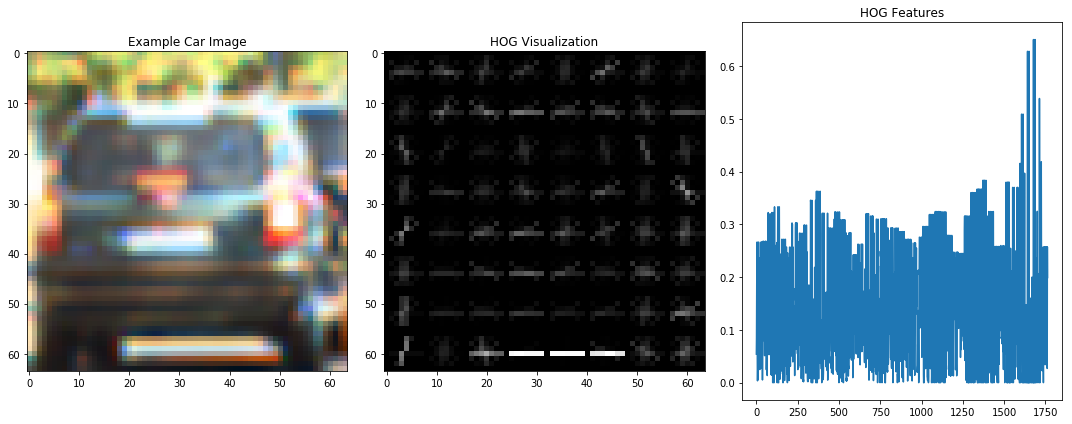

In [9]:
# Generate a random index to look at a car image
car_ind = np.random.randint(0, len(cars))

# Read in the image
image = cv2.imread(cars[car_ind])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True)

# Plot an example of raw and scaled features
fig = plt.figure(figsize=(15,6))
plt.subplot(131)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(132)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(133)
plt.plot(features)
plt.title('HOG Features')
fig.tight_layout()

---
## Combine Features

In [10]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial(), color_hist() and get_hog_features()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Parameter Selection for Feature Extraction & Training
---

In [11]:
# Reduce the sample size for faster execution
sample_size = 500
cars_sample = cars[0:sample_size]
notcars_sample = notcars[0:sample_size]

### Tweak these parameters and see how the results change.
color_space = ['RGB', 'HSV', 'YCrCb'] # Color spaces
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel =[0, 1, 2,'ALL']
spatial_size = [(16, 16),(32, 32)] # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# run multiple combinations and store results
parameters = []
classifier = 'LinearSVC'
if (not os.path.isfile('pickles/params_pickle.p')):    
    for color in color_space:
        for spatial in spatial_size:
            for channel in hog_channel:
                params = []
                t=time.time()
                cars_sample_features = extract_features(cars_sample, color_space=color, 
                                spatial_size=spatial, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

                notcars_sample_features = extract_features(notcars_sample, color_space=color, 
                                spatial_size=spatial, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
                t2 = time.time()
                extract_time = round(t2-t, 2)
                # Create an array stack of feature vectors
                X1 = np.vstack((cars_sample_features, notcars_sample_features)).astype(np.float64)

                # Define the labels vector
                y1 = np.hstack((np.ones(len(cars_sample_features)), np.zeros(len(notcars_sample_features))))

                # Split up data into randomized training and test sets
                rand_state = np.random.randint(0, 100)
                X1_train, X1_test, y1_train, y1_test = train_test_split(
                    X1, y1, test_size=0.2, random_state=rand_state)

                # Fit a per-column scaler
                X1_scaler = StandardScaler().fit(X1_train)
                # Apply the scaler to X
                X1_train = X1_scaler.transform(X1_train)
                X1_test = X1_scaler.transform(X1_test)
                # Use a linear SVC 
                svc1 = LinearSVC()
                # Check the training time for the SVC
                t=time.time()
                svc1.fit(X1_train, y1_train)
                t2 = time.time()
                train_time = round(t2-t, 2)
                # Check the score of the SVC
                accuracy = round(svc1.score(X1_test, y1_test), 4)
                # Add to params
                params.extend((color, spatial, hist_bins, orient, pix_per_cell,
                           cell_per_block, channel, classifier, extract_time, train_time, accuracy))
                parameters.append(params)
    pickle.dump(parameters, open('pickles/params_pickle.p', "wb"))
else:
    parameters = pickle.load(open('pickles/params_pickle.p', "rb"))

import pandas
indexes = list(range(1, 25))
headers = ['Color', 'Spatial Size', 'Hist Bins', 'Orient', 'Pix Per Cell','Cell Per Block', 'Hog Channel', 'Classifier', 'Extract Time', 'Train Time', 'Accuracy']

df = pandas.DataFrame(parameters, index = indexes, columns = headers)
df.style.apply(lambda x: ['background: lightgreen' if x.name == 17 else '' for i in x], axis=1)

### Generate and Normalize Train and Test data

In [12]:
# Reduce the sample size 
# sample_size = 50
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

### Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


# Load/Save Features
t=time.time()
if (not os.path.isfile('pickles/features_pickle.p')):    
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    pickle.dump((car_features, notcar_features), open('pickles/features_pickle.p', "wb"))
else:
    (car_features, notcar_features) = pickle.load(open('pickles/features_pickle.p', "rb"))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
    


print("Generated Train & Test Data")



12.14 Seconds to extract features...
Generated Train & Test Data


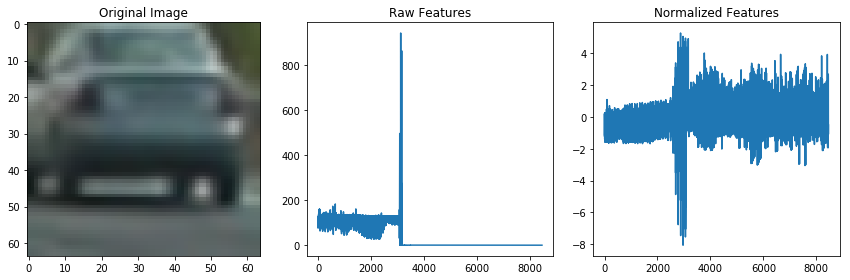

In [13]:
car_ind = np.random.randint(0, 50)
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(X_train[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

## Train & Validate the Model

In [14]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
9.39 Seconds to train SVC...
Test Accuracy of SVC =  0.9924


## Testing the Model

In [15]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

In [19]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.array(np.concatenate(img_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return box_list

In [20]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Testing the model on a test image

(32, 32)


D:\miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


2.2 Seconds to predict...


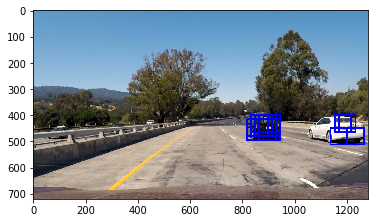

In [21]:
import pickle
# # load a pe-trained svc model from a serialized (pickle) file
# dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )

# # get attributes of our svc object
# svc = dist_pickle["svc"]
# X_scaler = dist_pickle["scaler"]
# orient = dist_pickle["orient"]
# pix_per_cell = dist_pickle["pix_per_cell"]
# cell_per_block = dist_pickle["cell_per_block"]
# spatial_size = dist_pickle["spatial_size"]
# hist_bins = dist_pickle["hist_bins"]

# print(orient)
# print(pix_per_cell)
# print(cell_per_block)
# print(spatial_size)
# print(hist_bins)

t=time.time()
image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ystart = 400
ystop = 720
scale = 1

print(spatial_size)
    
bboxes_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img = draw_boxes(image, bboxes_list)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to predict...')

plt.imshow(out_img)

### Using multiple scales

D:\miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


2.5 Seconds to predict...


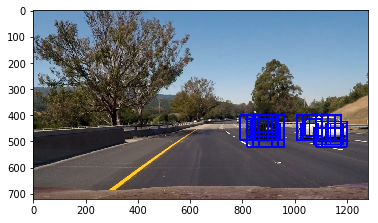

In [30]:

# # load a pe-trained svc model from a serialized (pickle) file
# dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )

# # get attributes of our svc object
# svc = dist_pickle["svc"]
# X_scaler = dist_pickle["scaler"]
# orient = dist_pickle["orient"]
# pix_per_cell = dist_pickle["pix_per_cell"]
# cell_per_block = dist_pickle["cell_per_block"]
# spatial_size = dist_pickle["spatial_size"]
# hist_bins = dist_pickle["hist_bins"]

# print(orient)
# print(pix_per_cell)
# print(cell_per_block)
# print(spatial_size)
# print(hist_bins)

t=time.time()
image = cv2.imread('test_images/test6.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ystart = 400
ystop = 720
scale = 1

box_list = []
    
box_list1 = find_cars(image, ystart, ystop, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
box_list2 = find_cars(image, ystart, ystop, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

if((len(box_list1) + len(box_list2)) > 0):
    box_list = box_list1 + box_list2

t2 = time.time()
print(round(t2-t, 2), 'Seconds to predict...')

out_img = draw_boxes(image, box_list)
plt.imshow(out_img)

## Multiple Detections & False Positives

### Heat Map & Thresholding

In [23]:
def add_heat(heatmap, bbox_list):
    if(len(bbox_list)>0):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

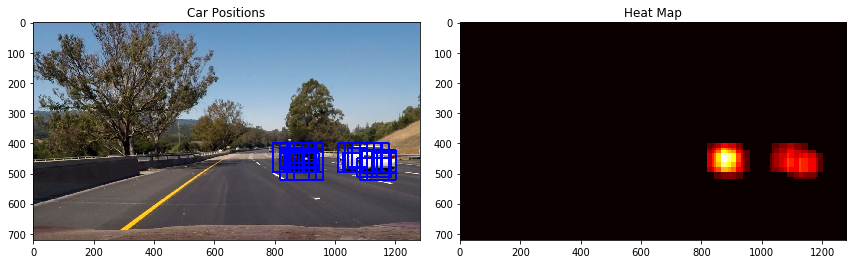

In [24]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(out_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


### Finding Cars from Heatmaps

2 cars found


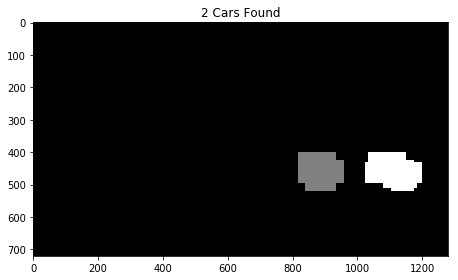

In [25]:
# Find final boxes from heatmap using label function
labels = label(heatmap)
print(labels[1], 'cars found')
fig = plt.figure(figsize=(12,4))
plt.imshow(labels[0], cmap='gray')
plt.title(str(labels[1]) + ' Cars Found')
fig.tight_layout()


### Draw Final Boxes

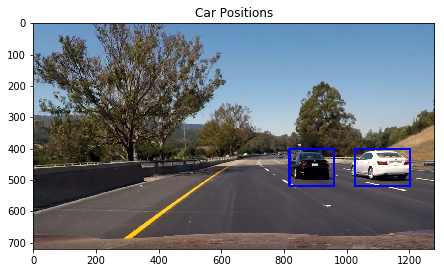

In [26]:
# Find final boxes from heatmap using label function
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
fig.tight_layout()

## Image Pipeline

In [27]:
def pipeline(image, cars_list = None, videoMode = False, heatMap = False, thresh = 0):
    
    # Calculate bounding boxes

    box_list = []

    box_list1 = find_cars(image, 400, 720, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list2 = find_cars(image, 400, 720, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    if len(box_list1) > 0 and len(box_list2) > 0:
        box_list = np.vstack(( box_list1, box_list2))
    elif(len(box_list1) > 0):
        box_list = box_list1
    elif(len(box_list2) > 0):
        box_list = box_list2           
        
    if(videoMode):
        if(len(box_list) > 0):
            cars_list.add_boxes(box_list)
        if(len(cars_list.prev_boxes) > 0):
            box_list = np.vstack(cars_list.prev_boxes)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,thresh)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    if heatMap:
        return draw_img, heatmap
    return draw_img

D:\miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


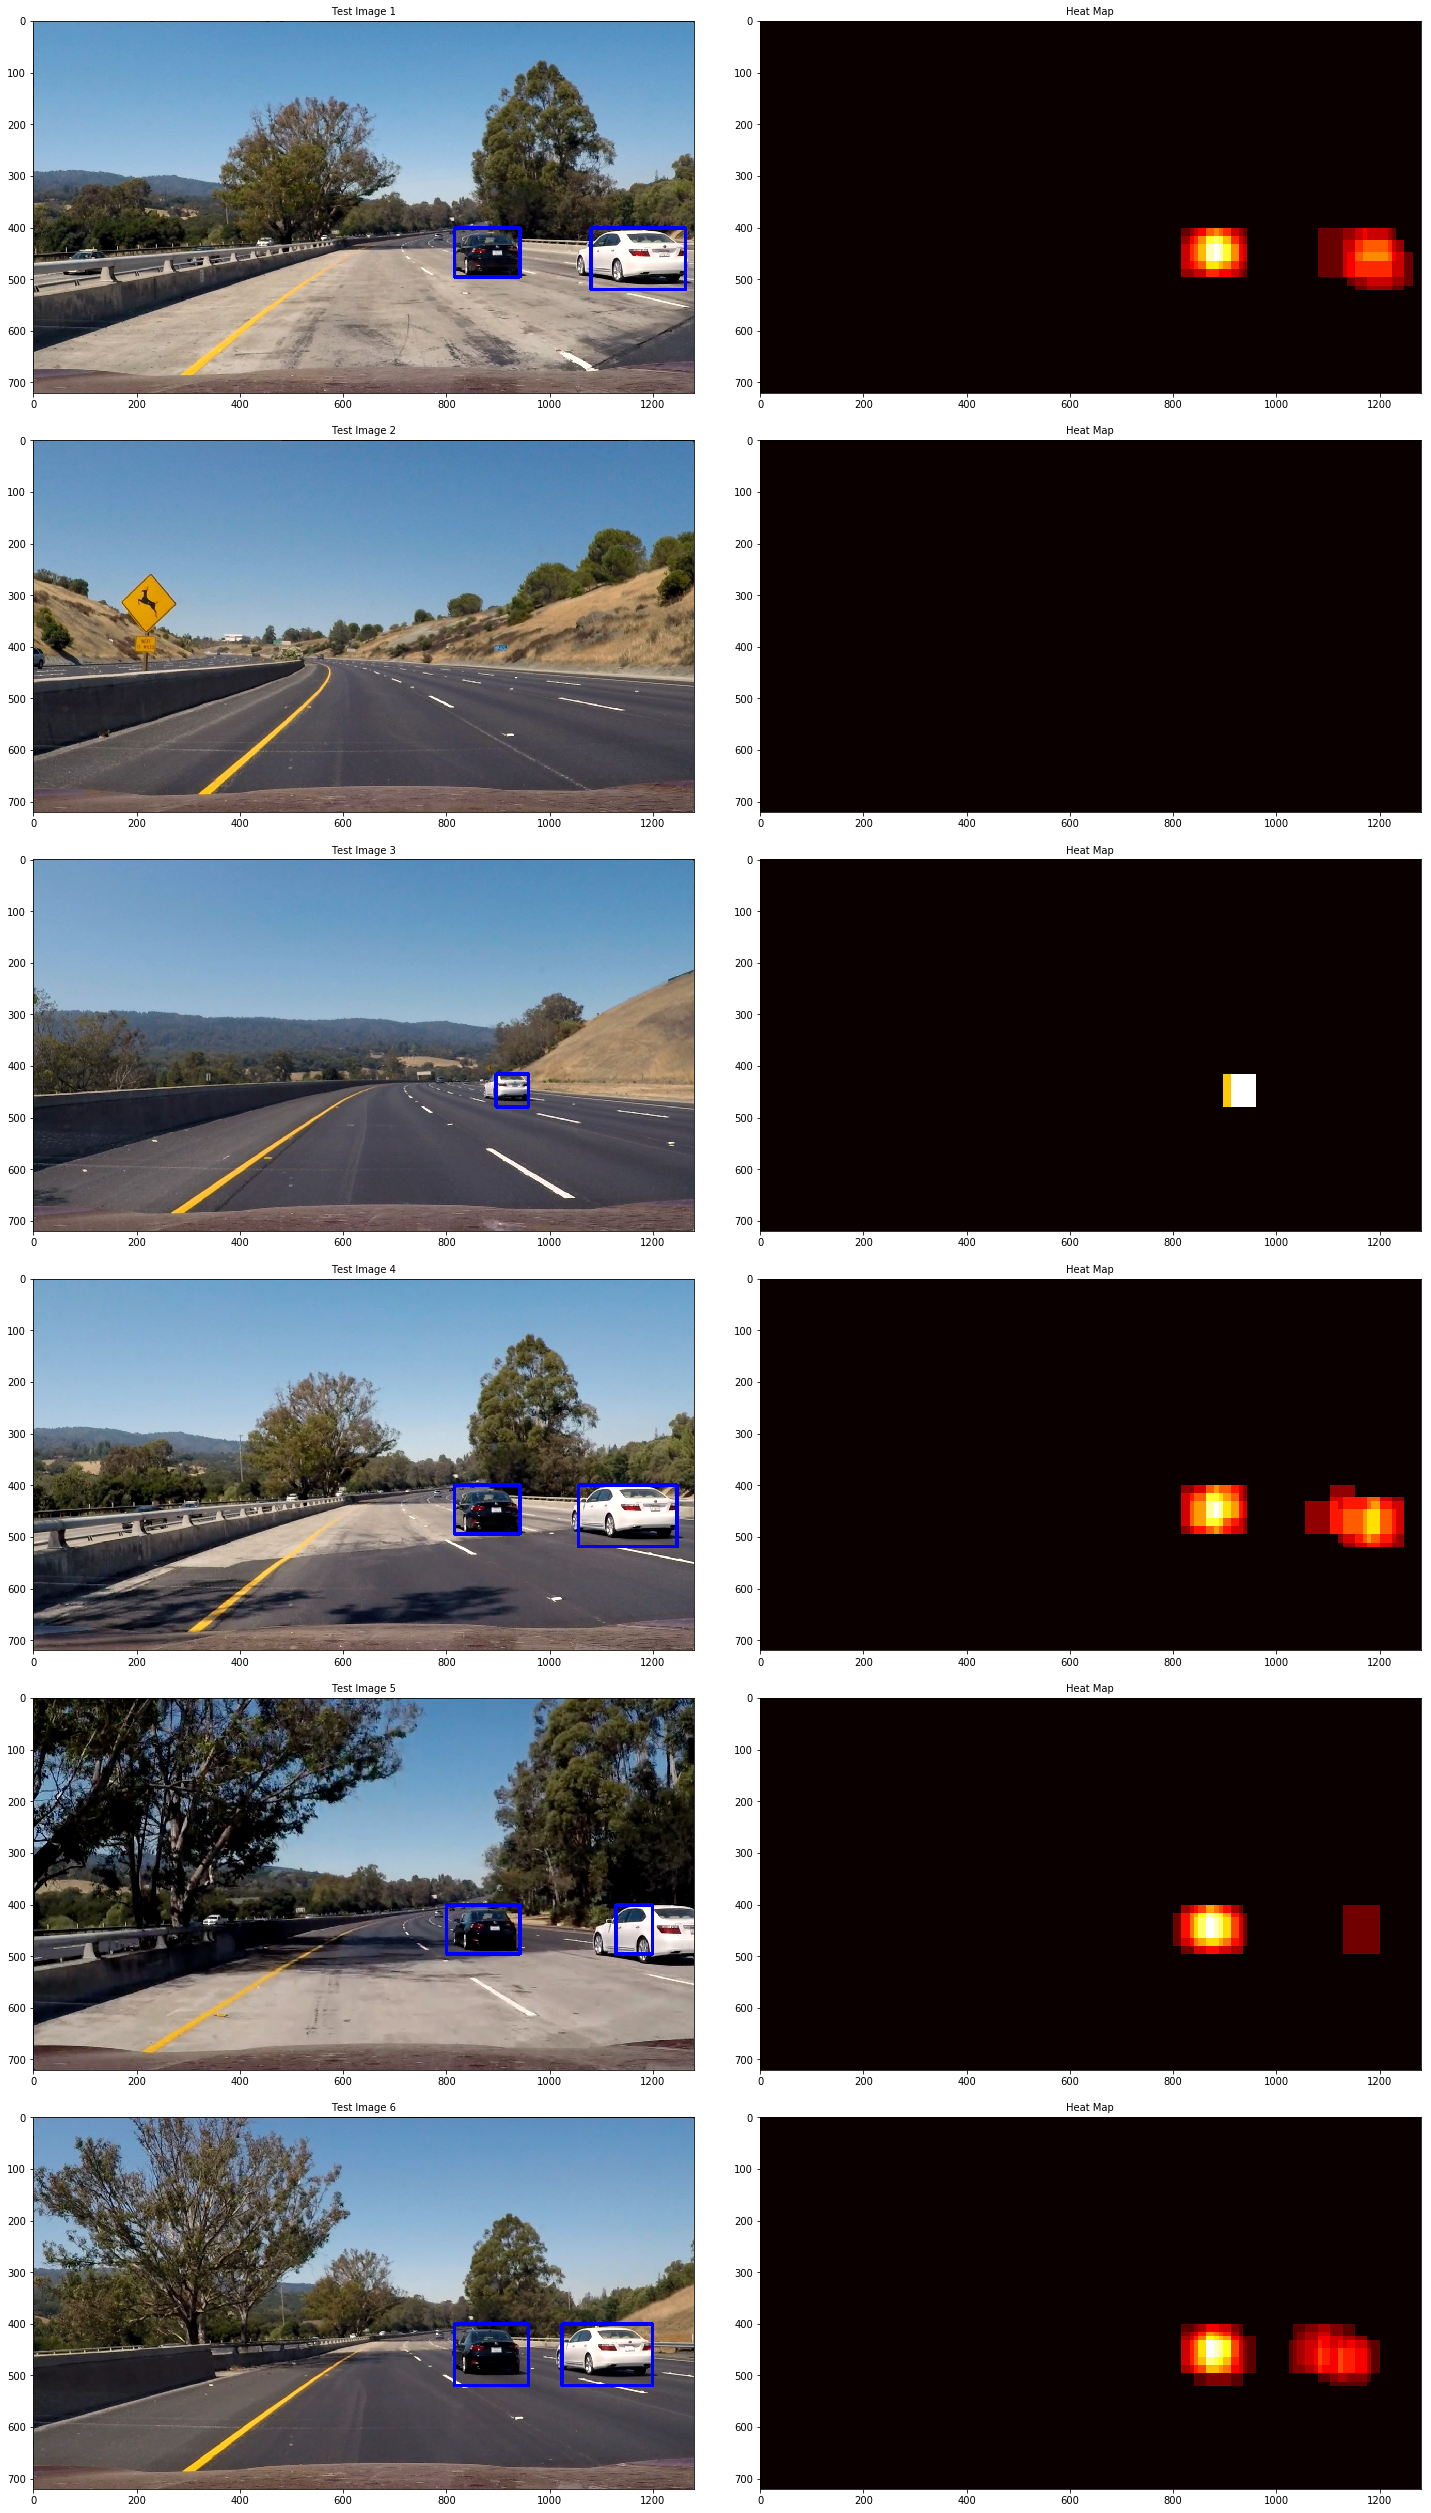

In [28]:
# Make a list of calibration images
images = glob.glob('test_images/test*.jpg')

f, axes = plt.subplots(6, 2, figsize=(20, 35))
f.tight_layout()

for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    
    final_result,heat_img = pipeline(img, thresh = 1, heatMap = True)
    mpimg.imsave('output_images/test' + str(idx+1) + '.jpg', final_result)
    # Plot the result    

    axes[idx,0].imshow(final_result)
    axes[idx,0].set_title('Test Image ' + str(idx+1), fontsize=10)

    axes[idx,1].imshow(heat_img, cmap='hot')
    axes[idx,1].set_title('Heat Map', fontsize=10)
    

plt.subplots_adjust(wspace=0.1, hspace=0.1)

## Define a Class to Store Cars Data

In [31]:
# Define a class to store data from video
class Cars():
    def __init__(self):
        # previous boxes / n frames
        self.prev_boxes = [] 
        
    def add_boxes(self, boxes):
        self.prev_boxes.append(boxes)
        if len(self.prev_boxes) > 10:
            # throw out oldest boxes
            self.prev_boxes.pop(0)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on three provided videos:

`test_video.mp4`

`project_video.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [35]:
def process_image(image, cars_list, thresh):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    return pipeline(image, cars_list = cars_list, videoMode = True, thresh = thresh)

---
## Test pipeline on test_video.mp4
---

In [36]:
cars = Cars()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'test_video_output.mp4'
video_input1 = VideoFileClip('test_video.mp4')#.subclip(0,1)
processed_video1 = video_input1.fl_image(lambda image: process_image(image,cars,10))
%time processed_video1.write_videofile(video_output1, audio=False)
video_input1.close()

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:35<00:02,  2.50s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 1min 39s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))

---
## Test pipeline on project_video.mp4
---

In [38]:
cars = Cars()
#my_clip.write_gif('test.gif', fps=12)
video_output2 = 'project_video_output.mp4'
video_input2 = VideoFileClip('project_video.mp4')#.subclip(0,1)
processed_video2 = video_input2.fl_image(lambda image: process_image(image,cars,15))
%time processed_video2.write_videofile(video_output2, audio=False)
video_input2.close()

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [51:45<00:02,  2.46s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 51min 49s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output2))